## Find missing authors

In [ ]:
import os
from utils import read_data

data_dir = 'data'

In [3]:
affiliations = read_data(f'{data_dir}/affiliations.json')

In [11]:
import os
for affiliation in affiliations:
    affiliation_name = affiliation['affiliation']
    print(affiliation_name)
    required = affiliation['researchers']

    available = []
    affiliation_dir = f'{data_dir}/{affiliation_name}'
    for file in os.listdir(affiliation_dir):
        researcher = read_data(f'{affiliation_dir}/{file}')
        names = researcher['name'].split(', ')
        first_name = names[-1]
        last_name = '' if len(names) < 2 else names[0]
        available.append(f'{first_name} {last_name}'.strip())

    available_set = set([a.lower() for a in available])
    required_set = set([r.lower() for r in required])
    unmatched_required = list(required_set - available_set)
    unmatched_available = list(available_set - required_set)
    unmatched_required.sort()
    unmatched_available.sort()
    
    print(f"{'Missing'.rjust(25)}\t| Available")
    for i in range(len(unmatched_required)):
        item1 = unmatched_required[i]
        item2 = unmatched_available[i] if i < len(unmatched_available) else ""
        print(f"{item1.rjust(25)}\t| {item2}")
    
    print('------------------------------\n')

University of Adelaide
                  Missing	| Available
            azmeraw amare	| azmeraw t. amare
             daniel brown	| daniel david brown
            david ottaway	| david j. ottaway
               ian d reid	| ian d. reid
               john lynch	| john william lynch
         lyle john palmer	| lyle j. palmer
             paul jackson	| paul d. jackson
       philippa middleton	| philippa f. middleton
            robert norman	| robert john norman
           shi zhang qiao	| shizhang zhang qiao
           tiffany k gill	| tiffany k. gill
               tml wigley	| 
------------------------------

Australian National University
                  Missing	| Available
              andrew wade	| andrew r. wade
           brian anderson	| brian d.o. anderson
            brian schmidt	| brian p. schmidt
             craig moritz	| craig c. moritz
          daniel shaddock	| daniel a. shaddock
        david lindenmayer	| david b. lindenmayer
            gavin huttley	| gavin

## Plots

In [3]:
%pip install -qr requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Total Citations by University (Column Chart)
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import read_data

# Function to load author data from JSON files
def load_author_data(data_dir):
    author_data = {}
    for affiliation in os.listdir(data_dir):
        affiliation_path = os.path.join(data_dir, affiliation)
        if os.path.isdir(affiliation_path):
            author_data[affiliation] = []
            for author_file in os.listdir(affiliation_path):
                if author_file.endswith('.json'):
                    author_path = os.path.join(affiliation_path, author_file)
                    author_data[affiliation].append(read_data(author_path))  # Replace with your read_data function
    return author_data

data_directory = 'data'  # Replace with your data directory path
author_data = load_author_data(data_directory)

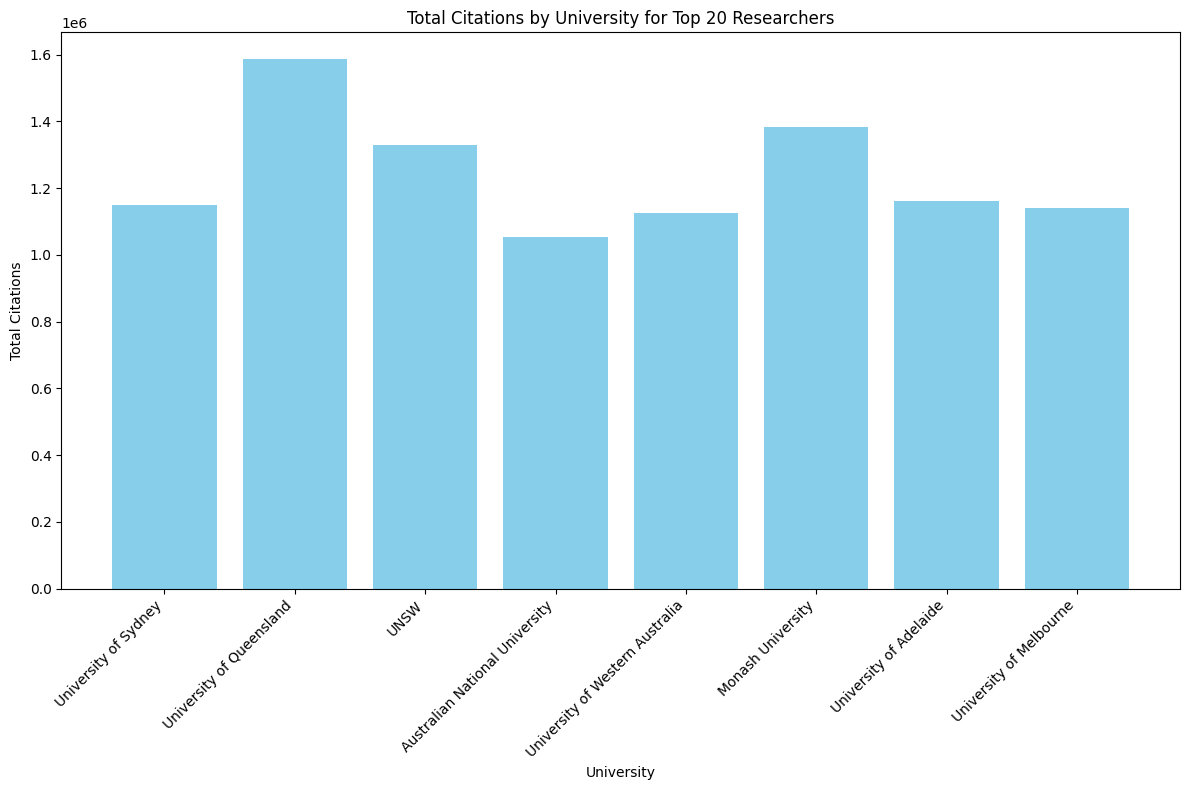

In [8]:
# Total Citations by University (Column Chart)
citations_data = []
for affiliation, authors in author_data.items():
    citations_data.append(0)
    for author in authors:
        citations_data[-1] += sum(pub['citations'] for pub in author['publications'])

# Plotting using Matplotlib
plt.figure(figsize=(12, 8))
plt.bar(author_data.keys(), citations_data, color='skyblue')
plt.xlabel('University')
plt.ylabel('Total Citations')
plt.title('Total Citations by University for Top 20 Researchers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

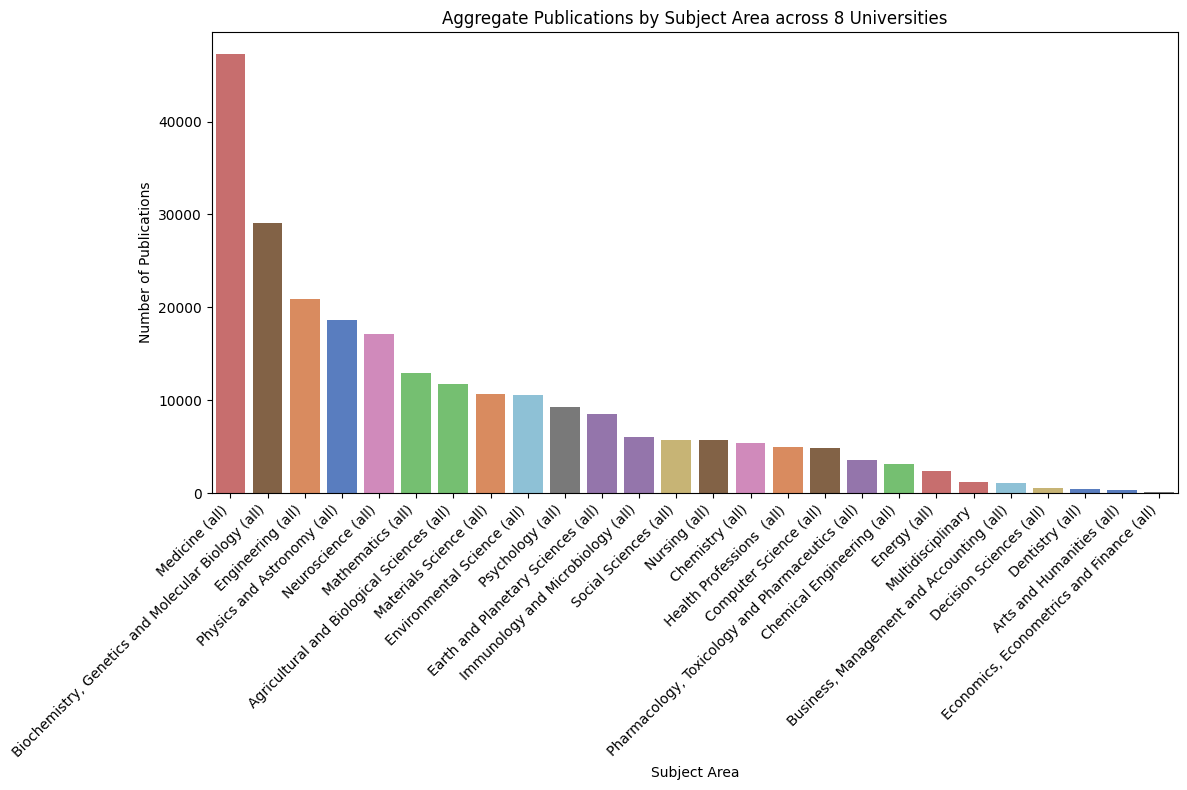

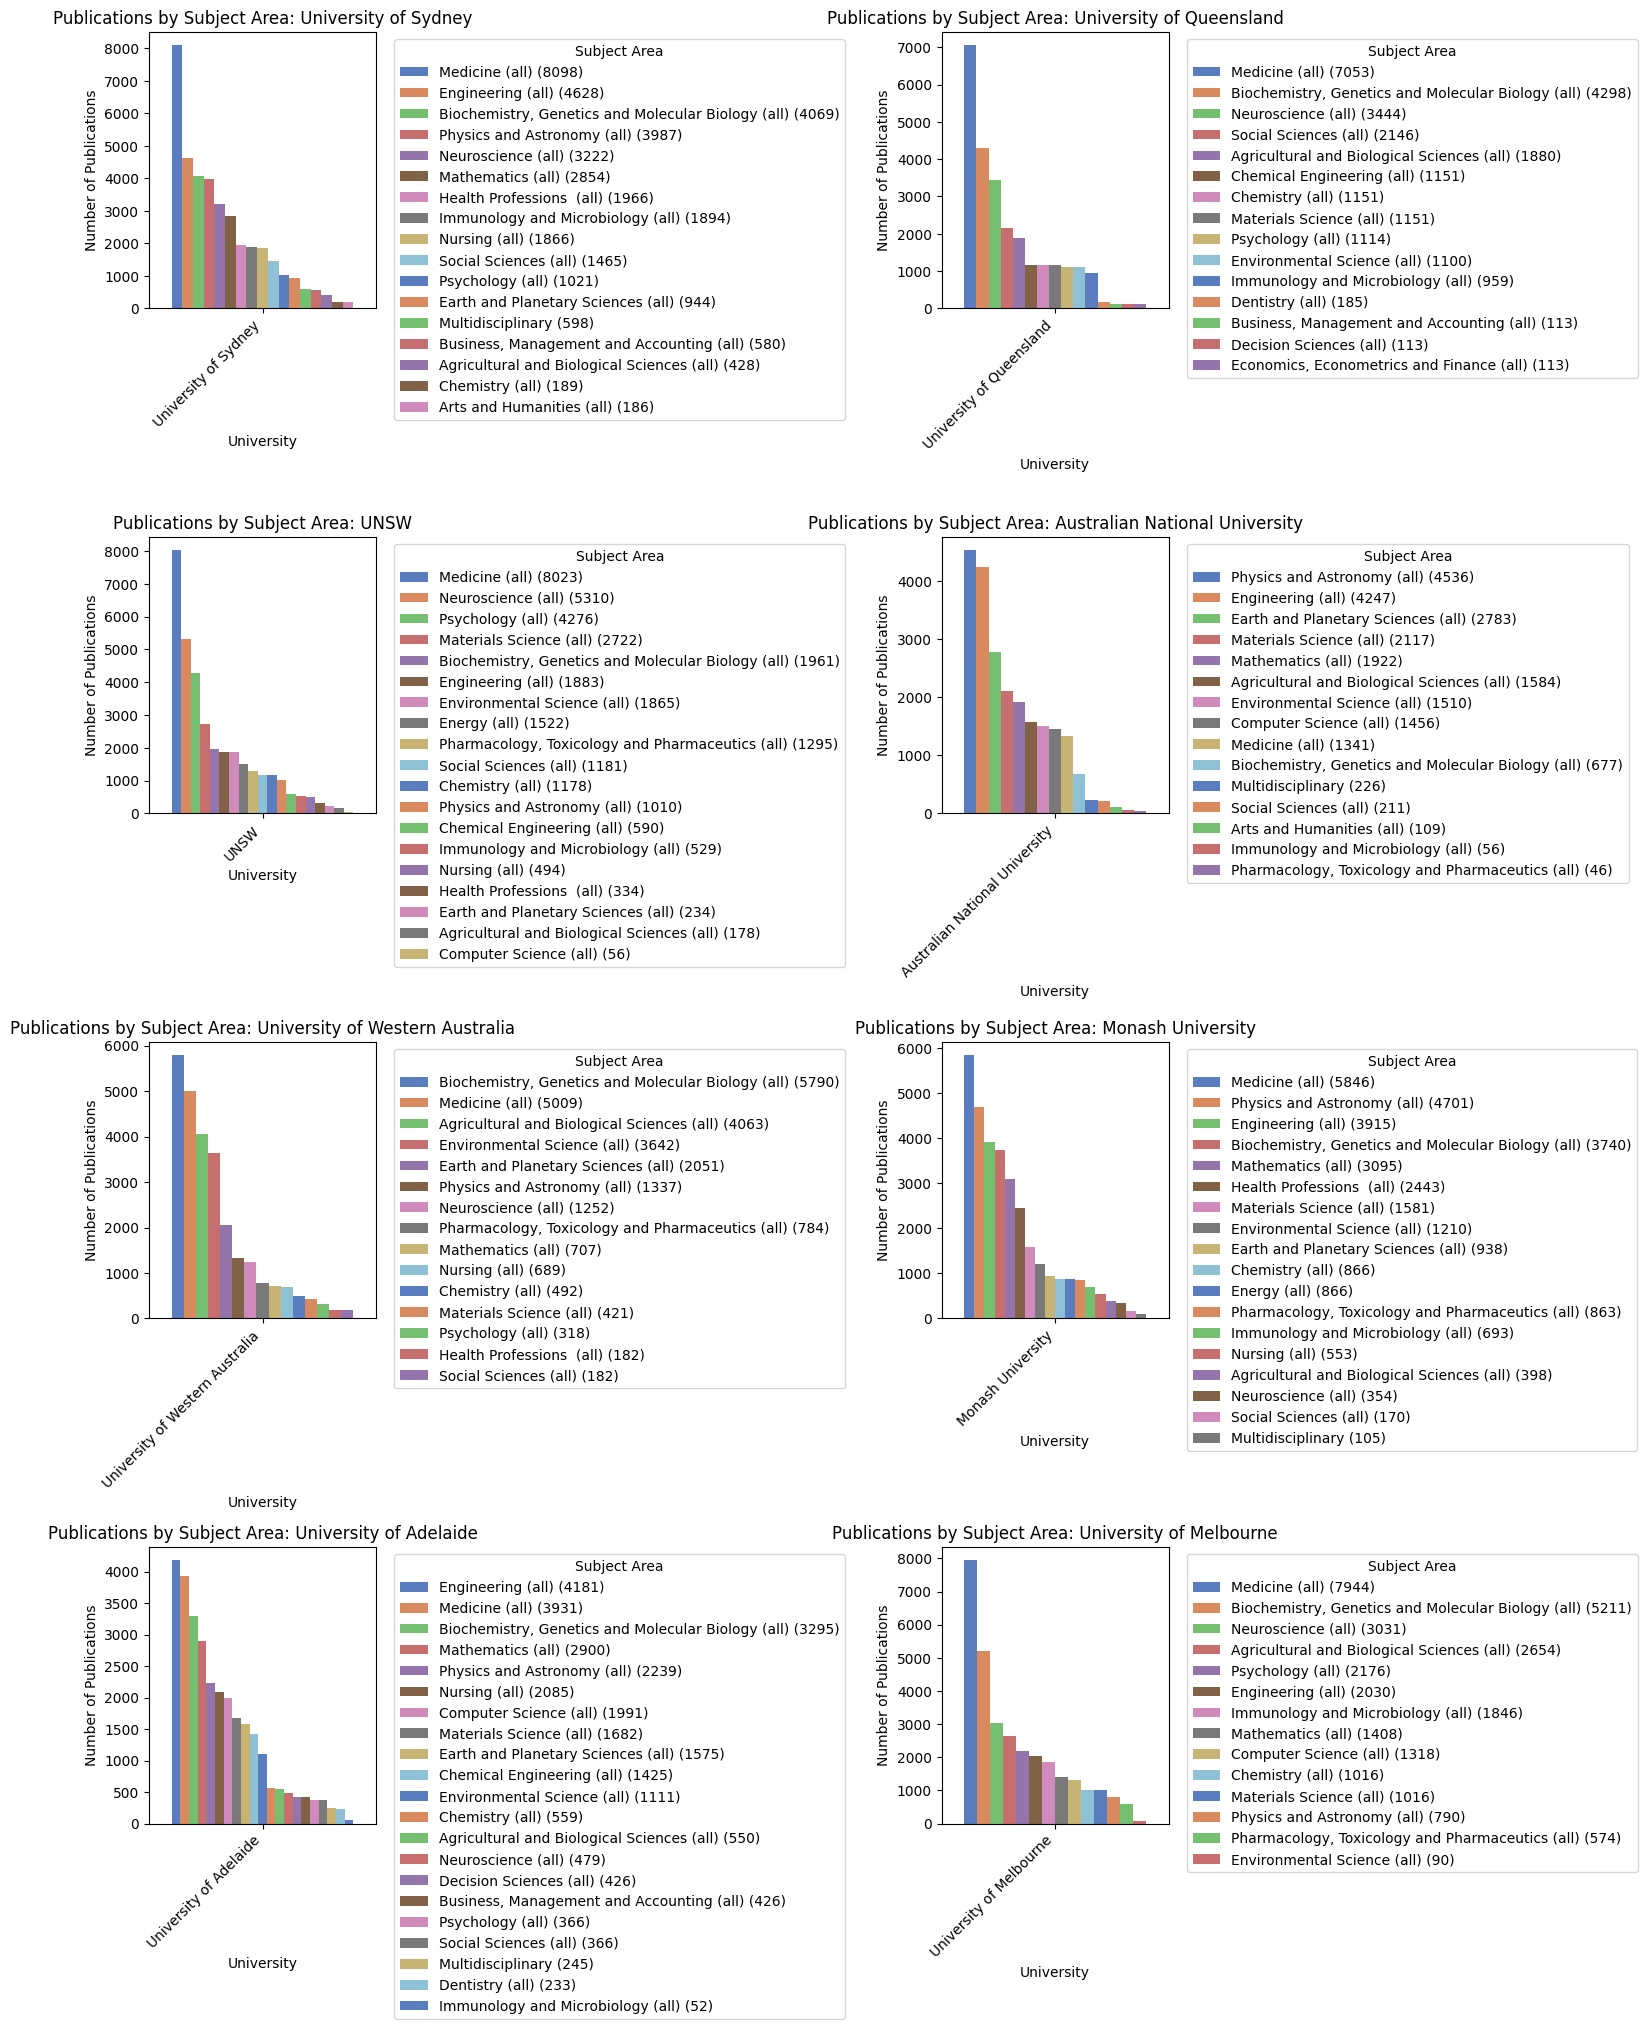

In [19]:
# Function to prepare data for publications by subject area
def publications_by_subject_area(author_data, university):
    publications_data = []
    for author in author_data[university]:
        for pub in author['publications']:
            for subject in author['subject_area']:
                publications_data.append({
                    'University': university,
                    'Subject Area': subject['$'],
                    'Publication Count': 1
                })
    publications_df = pd.DataFrame(publications_data)
    return publications_df

# Example usage for plotting 8 universities
universities = list(author_data.keys())[:8]  # Assuming you have 8 universities

# Aggregate data across all universities
aggregate_publications_data = []
for university in universities:
    publications_df = publications_by_subject_area(author_data, university)
    aggregate_publications_data.append(publications_df)
    
# Concatenate dataframes for all universities
aggregate_df = pd.concat(aggregate_publications_data)

# Calculate total publication counts for each subject area across all universities
subject_counts_all = aggregate_df.groupby('Subject Area')['Publication Count'].sum()
sorted_subjects_all = subject_counts_all.sort_values(ascending=False).index.tolist()

# Plotting the aggregated data using Seaborn (sorted by publication count)
plt.figure(figsize=(12, 8))
sns.barplot(x='Subject Area', y='Publication Count', hue='Subject Area', data=aggregate_df,
            estimator=np.sum, palette='muted', order=sorted_subjects_all)

plt.xlabel('Subject Area')
plt.ylabel('Number of Publications')
plt.title('Aggregate Publications by Subject Area across 8 Universities')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting individual university data (8 separate plots)
plt.figure(figsize=(16, 20))  # Adjust figure size as needed
for i, university in enumerate(universities):
    plt.subplot(4, 2, i+1)  # Create subplot for each university
    publications_df = publications_by_subject_area(author_data, university)
    
    # Calculate total publication counts for each subject area
    subject_counts = publications_df.groupby('Subject Area')['Publication Count'].sum()
    sorted_subjects = subject_counts.sort_values(ascending=False).index.tolist()

    # Plot using Seaborn (sorted by publication count)
    sns.barplot(x='University', y='Publication Count', hue='Subject Area', data=publications_df,
                estimator=np.sum, palette='muted', ax=plt.gca(), hue_order=sorted_subjects)

    # Customizing legend to include count next to subject area
    handles, labels = plt.gca().get_legend_handles_labels()
    legend_labels = [f"{label} ({subject_counts[label]})" for label in sorted_subjects]
    plt.legend(handles, legend_labels, title='Subject Area', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('University')
    plt.ylabel('Number of Publications')
    plt.title(f'Publications by Subject Area: {university}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

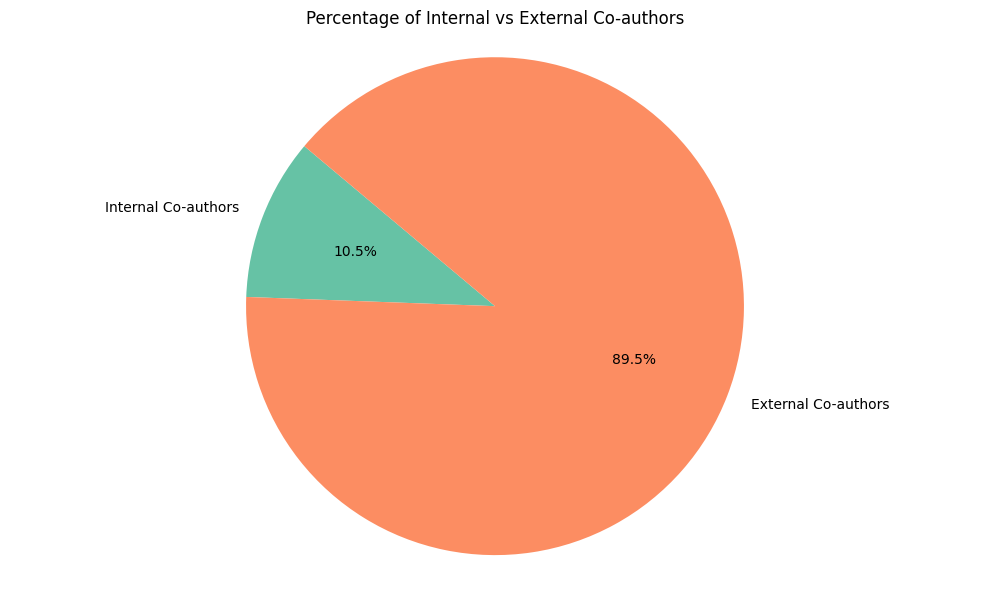

In [20]:
# Function to calculate internal vs external co-authors
def internal_vs_external_coauthors(author_data):
    coauthors_data = []
    for affiliation, authors in author_data.items():
        for author in authors:
            internal_count = 0
            external_count = 0
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    if coauthor['scopus_id'] == author['scopus_id']:
                        internal_count += 1
                    else:
                        external_count += 1
            total_coauthors = internal_count + external_count
            if total_coauthors > 0:
                coauthors_data.append({
                    'University': affiliation,
                    'Internal Co-authors (%)': (internal_count / total_coauthors) * 100,
                    'External Co-authors (%)': (external_count / total_coauthors) * 100
                })
    coauthors_df = pd.DataFrame(coauthors_data)
    return coauthors_df

# Example usage:
coauthors_df = internal_vs_external_coauthors(author_data)

# Plotting using Matplotlib (pie chart)
plt.figure(figsize=(10, 6))
labels = ['Internal Co-authors', 'External Co-authors']
colors = ['#66c2a5', '#fc8d62']
plt.pie(coauthors_df[['Internal Co-authors (%)', 'External Co-authors (%)']].sum(), labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Percentage of Internal vs External Co-authors')
plt.axis('equal')
plt.tight_layout()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (8,) and arg 3 with shape (160,).

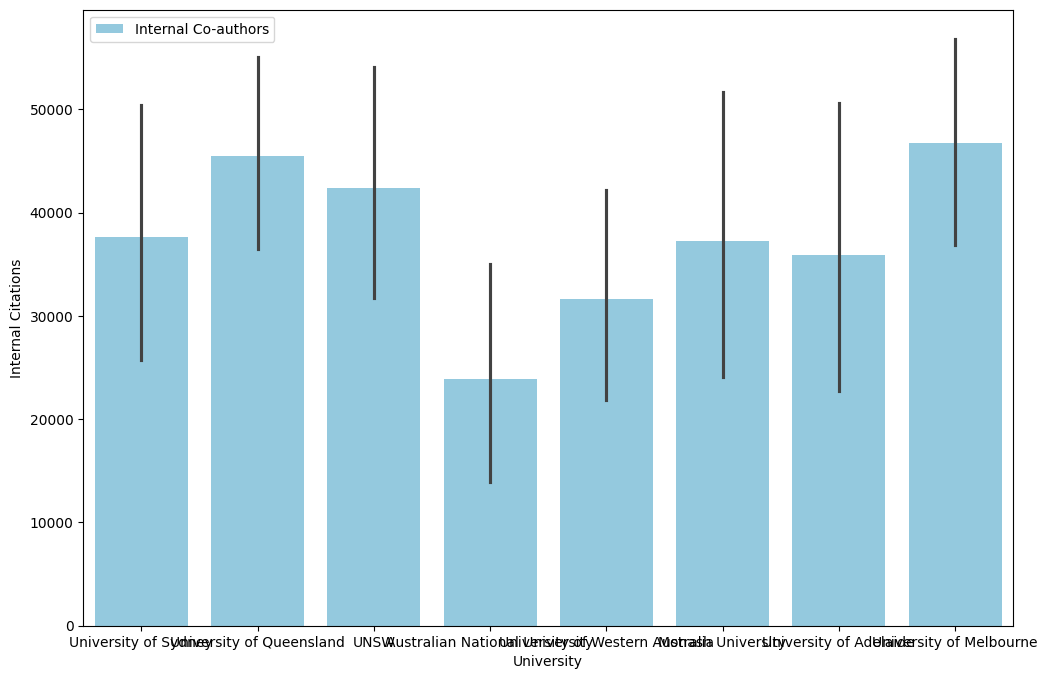

In [21]:
# Function to calculate citations by internal vs external co-authors
def citations_by_internal_external_coauthors(author_data):
    citations_data = []
    for affiliation, authors in author_data.items():
        for author in authors:
            internal_citations = 0
            external_citations = 0
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    if coauthor['scopus_id'] == author['scopus_id']:
                        internal_citations += pub['citations']
                    else:
                        external_citations += pub['citations']
            citations_data.append({
                'University': affiliation,
                'Internal Citations': internal_citations,
                'External Citations': external_citations
            })
    citations_df = pd.DataFrame(citations_data)
    return citations_df

# Example usage:
citations_df = citations_by_internal_external_coauthors(author_data)

# Plotting using Seaborn (stacked bar chart)
plt.figure(figsize=(12, 8))
sns.barplot(x='University', y='Internal Citations', data=citations_df, color='skyblue', label='Internal Co-authors')
sns.barplot(x='University', y='External Citations', data=citations_df, color='orange', bottom=citations_df['Internal Citations'], label='External Co-authors')
plt.xlabel('University')
plt.ylabel('Total Citations')
plt.title('Citations by Internal vs External Co-authors')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Co-authors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


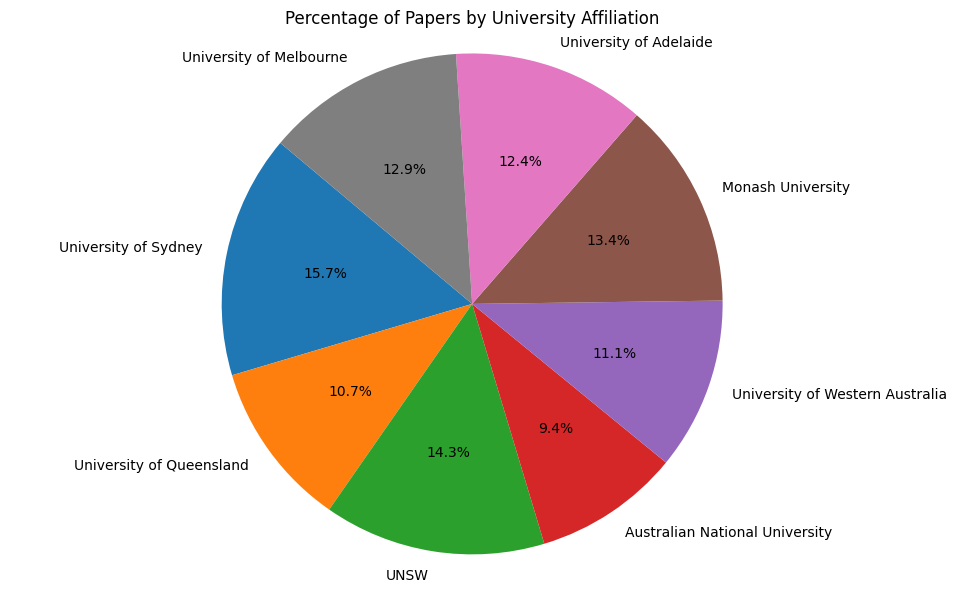

In [22]:
# Function to calculate percentage of papers by university affiliation
# NOTE: This is wrong and needs to be corrected.
def percentage_papers_by_university(author_data):
    papers_data = []
    total_papers = sum(sum(len(author['publications']) for author in authors) for authors in author_data.values())
    for affiliation, authors in author_data.items():
        affiliation_papers = sum(len(author['publications']) for author in authors)
        papers_data.append({
            'University': affiliation,
            'Percentage of Papers': (affiliation_papers / total_papers) * 100
        })
    papers_df = pd.DataFrame(papers_data)
    return papers_df

# Example usage:
papers_df = percentage_papers_by_university(author_data)

# Plotting using Matplotlib (pie chart)
plt.figure(figsize=(10, 6))
plt.pie(papers_df['Percentage of Papers'], labels=papers_df['University'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Papers by University Affiliation')
plt.axis('equal')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1589362/875904170.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='University', y='Median Co-authors', data=median_coauthors_df, palette='muted')


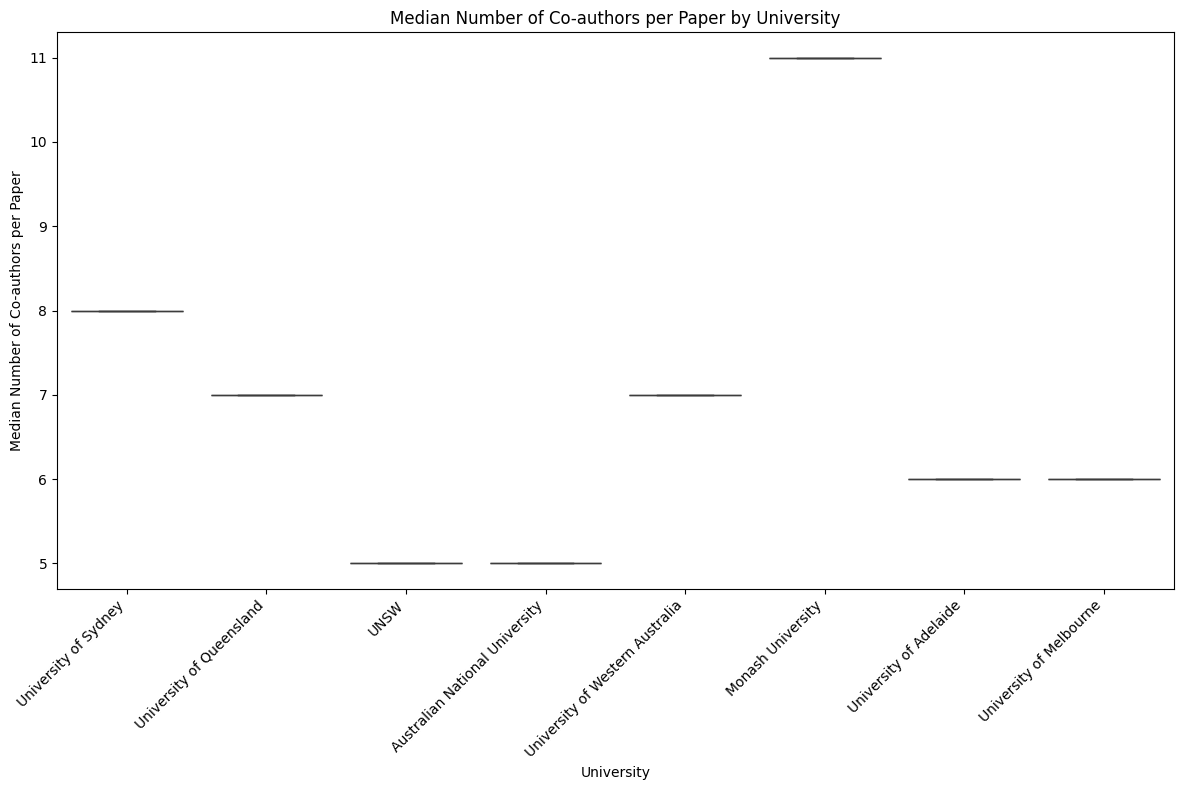

In [23]:
# Function to calculate median number of co-authors per paper by university
def median_coauthors_by_university(author_data):
    coauthors_data = []
    for affiliation, authors in author_data.items():
        coauthor_counts = []
        for author in authors:
            coauthor_counts.extend(len(pub['authors']) for pub in author['publications'])
        coauthors_data.append({
            'University': affiliation,
            'Median Co-authors': np.median(coauthor_counts)
        })
    coauthors_df = pd.DataFrame(coauthors_data)
    return coauthors_df

# Example usage:
median_coauthors_df = median_coauthors_by_university(author_data)

# Plotting using Seaborn (box plot)
plt.figure(figsize=(12, 8))
sns.boxplot(x='University', y='Median Co-authors', data=median_coauthors_df, palette='muted')
plt.xlabel('University')
plt.ylabel('Median Number of Co-authors per Paper')
plt.title('Median Number of Co-authors per Paper by University')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


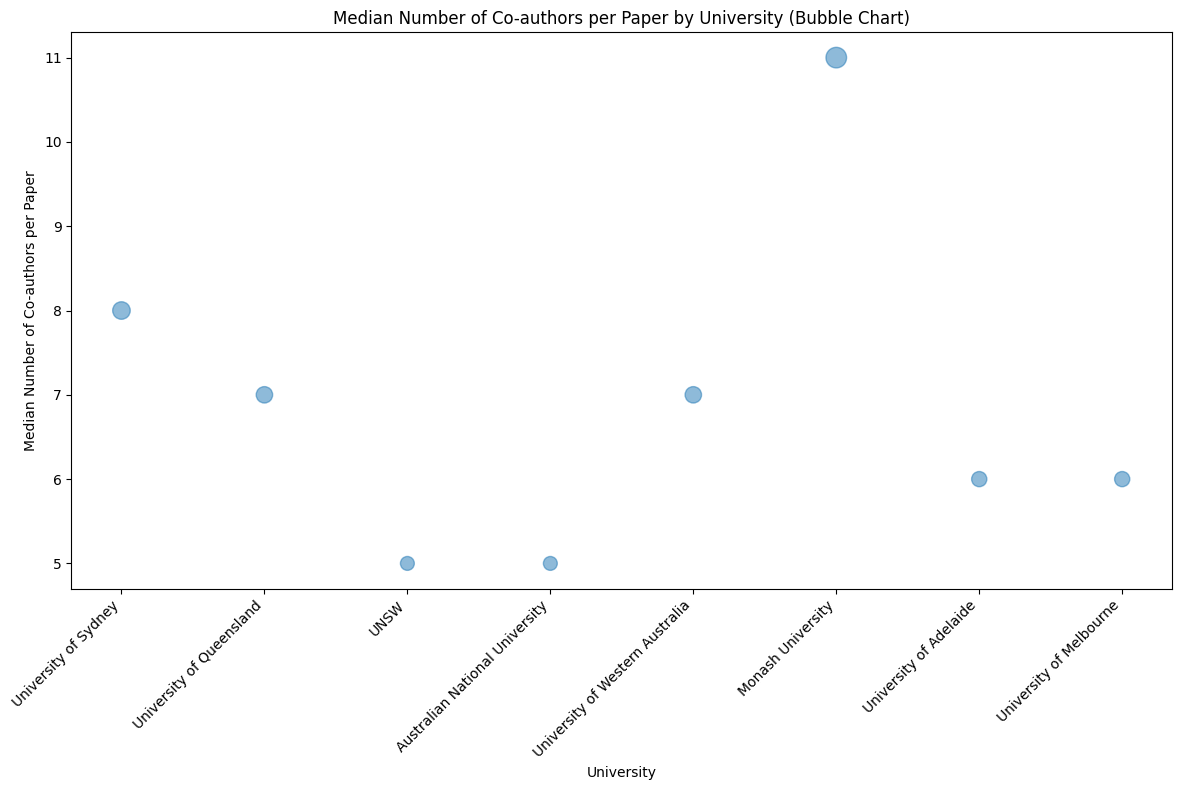

In [24]:
# Plotting using Matplotlib (bubble chart)
plt.figure(figsize=(12, 8))
plt.scatter(median_coauthors_df['University'], median_coauthors_df['Median Co-authors'], s=median_coauthors_df['Median Co-authors']*20, alpha=0.5)
plt.xlabel('University')
plt.ylabel('Median Number of Co-authors per Paper')
plt.title('Median Number of Co-authors per Paper by University (Bubble Chart)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


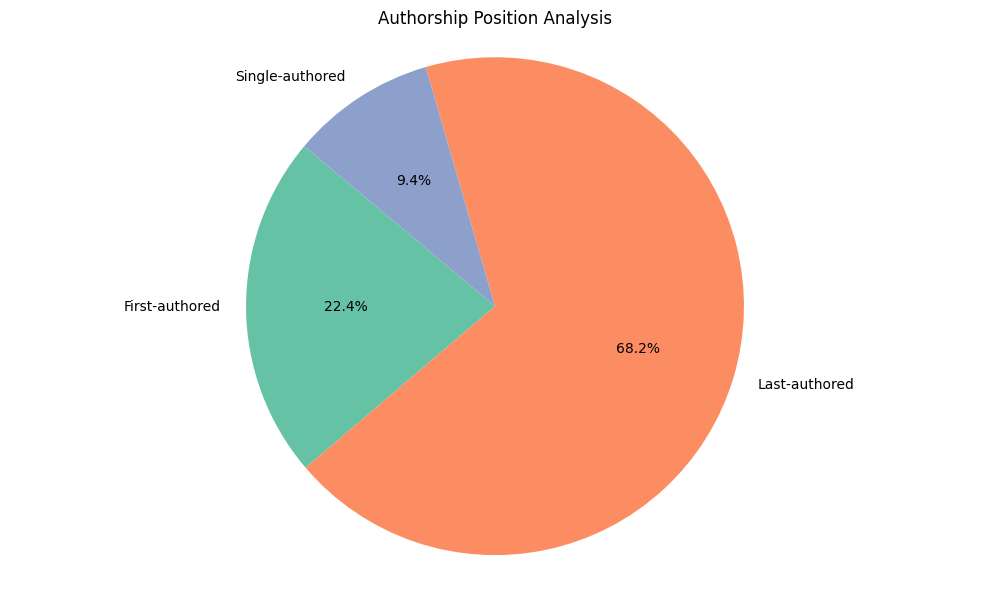

In [25]:
# NOTE: Needs to include middle authored count as well
# Function to calculate authorship position analysis
def authorship_position_analysis(author_data):
    position_data = []
    for affiliation, authors in author_data.items():
        first_count = 0
        last_count = 0
        single_count = 0
        for author in authors:
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
        total_papers = first_count + last_count + single_count
        if total_papers > 0:
            position_data.append({
                'University': affiliation,
                'First-authored (%)': (first_count / total_papers) * 100,
                'Last-authored (%)': (last_count / total_papers) * 100,
                'Single-authored (%)': (single_count / total_papers) * 100
            })
    position_df = pd.DataFrame(position_data)
    return position_df

# Example usage:
position_df = authorship_position_analysis(author_data)

# Plotting using Matplotlib (pie chart)
plt.figure(figsize=(10, 6))
labels = ['First-authored', 'Last-authored', 'Single-authored']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
plt.pie(position_df[['First-authored (%)', 'Last-authored (%)', 'Single-authored (%)']].sum(), labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Authorship Position Analysis')
plt.axis('equal')
plt.tight_layout()
plt.show()


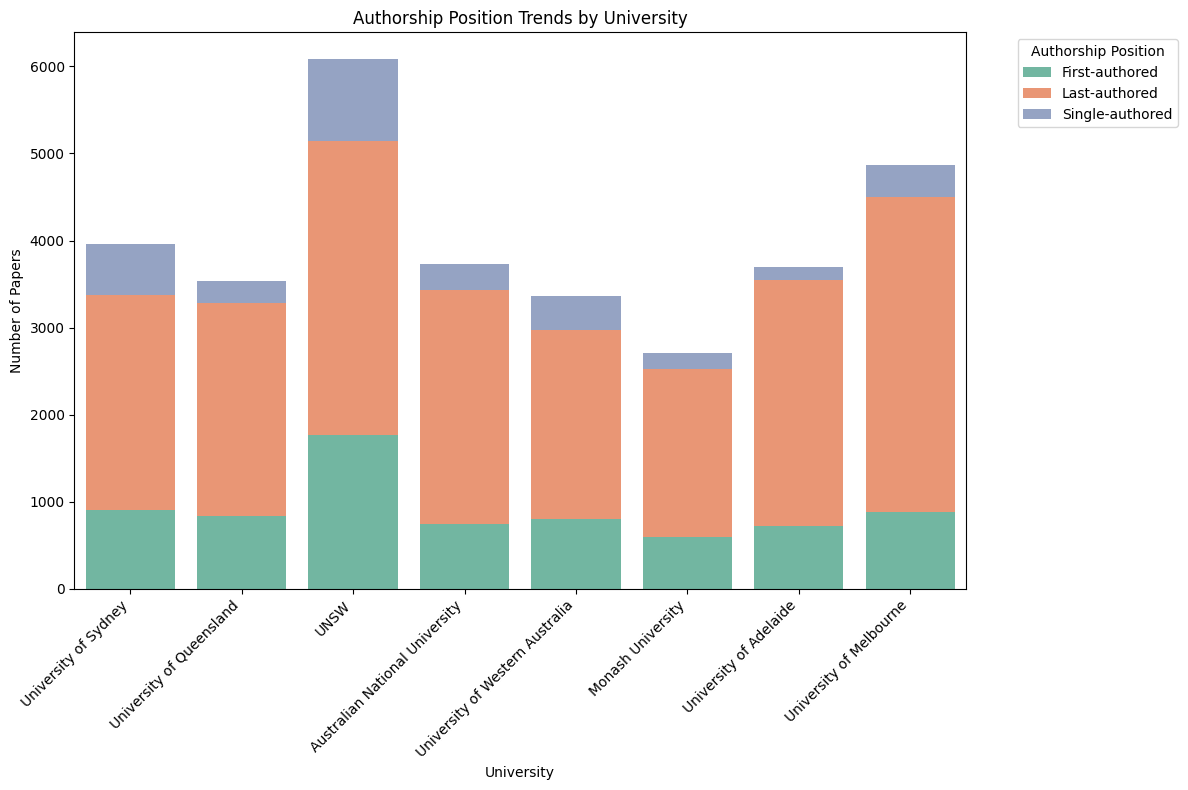

In [26]:
# NOTE: Needs to include middle authored count as well
# Function to calculate trends in authorship positions
def authorship_position_trends(author_data):
    trends_data = []
    for affiliation, authors in author_data.items():
        first_counts = []
        last_counts = []
        single_counts = []
        for author in authors:
            first_count = 0
            last_count = 0
            single_count = 0
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
            first_counts.append(first_count)
            last_counts.append(last_count)
            single_counts.append(single_count)
        trends_data.append({
            'University': affiliation,
            'First-authored': np.sum(first_counts),
            'Last-authored': np.sum(last_counts),
            'Single-authored': np.sum(single_counts)
        })
    trends_df = pd.DataFrame(trends_data)
    return trends_df

# Example usage:
trends_df = authorship_position_trends(author_data)

# Plotting using Seaborn (stacked bar chart)
plt.figure(figsize=(12, 8))
sns.barplot(x='University', y='First-authored', data=trends_df, color='#66c2a5', label='First-authored')
sns.barplot(x='University', y='Last-authored', data=trends_df, bottom=trends_df['First-authored'], color='#fc8d62', label='Last-authored')
sns.barplot(x='University', y='Single-authored', data=trends_df, bottom=trends_df['First-authored'] + trends_df['Last-authored'], color='#8da0cb', label='Single-authored')
plt.xlabel('University')
plt.ylabel('Number of Papers')
plt.title('Authorship Position Trends by University')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Authorship Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_1589362/3495435145.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='University', y='Median Citations per Paper', data=citations_df, palette='muted')


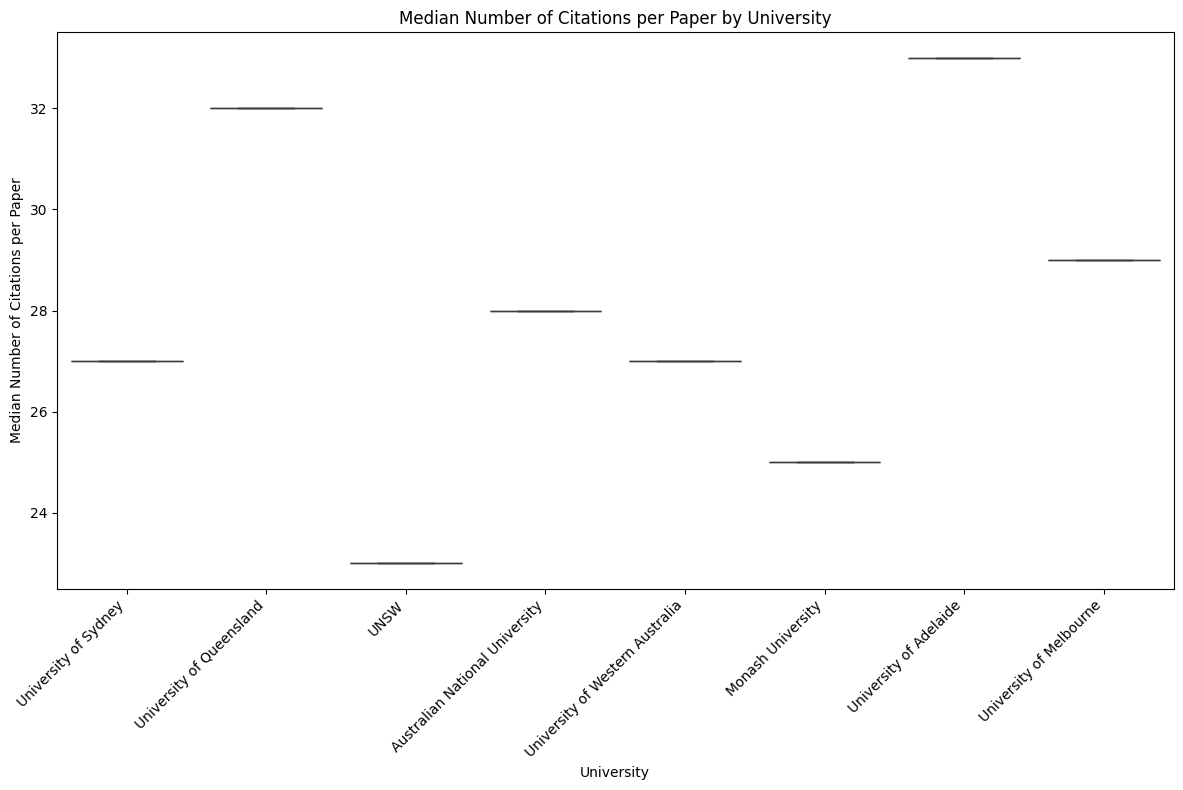

In [27]:
# Function to calculate median number of citations per paper by university
def median_citations_per_paper(author_data):
    citations_data = []
    for affiliation, authors in author_data.items():
        citations_per_paper = []
        for author in authors:
            for pub in author['publications']:
                citations_per_paper.append(pub['citations'])
        citations_data.append({
            'University': affiliation,
            'Median Citations per Paper': np.median(citations_per_paper)
        })
    citations_df = pd.DataFrame(citations_data)
    return citations_df

# Example usage:
citations_df = median_citations_per_paper(author_data)

# Plotting using Seaborn (box plot)
plt.figure(figsize=(12, 8))
sns.boxplot(x='University', y='Median Citations per Paper', data=citations_df, palette='muted')
plt.xlabel('University')
plt.ylabel('Median Number of Citations per Paper')
plt.title('Median Number of Citations per Paper by University')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


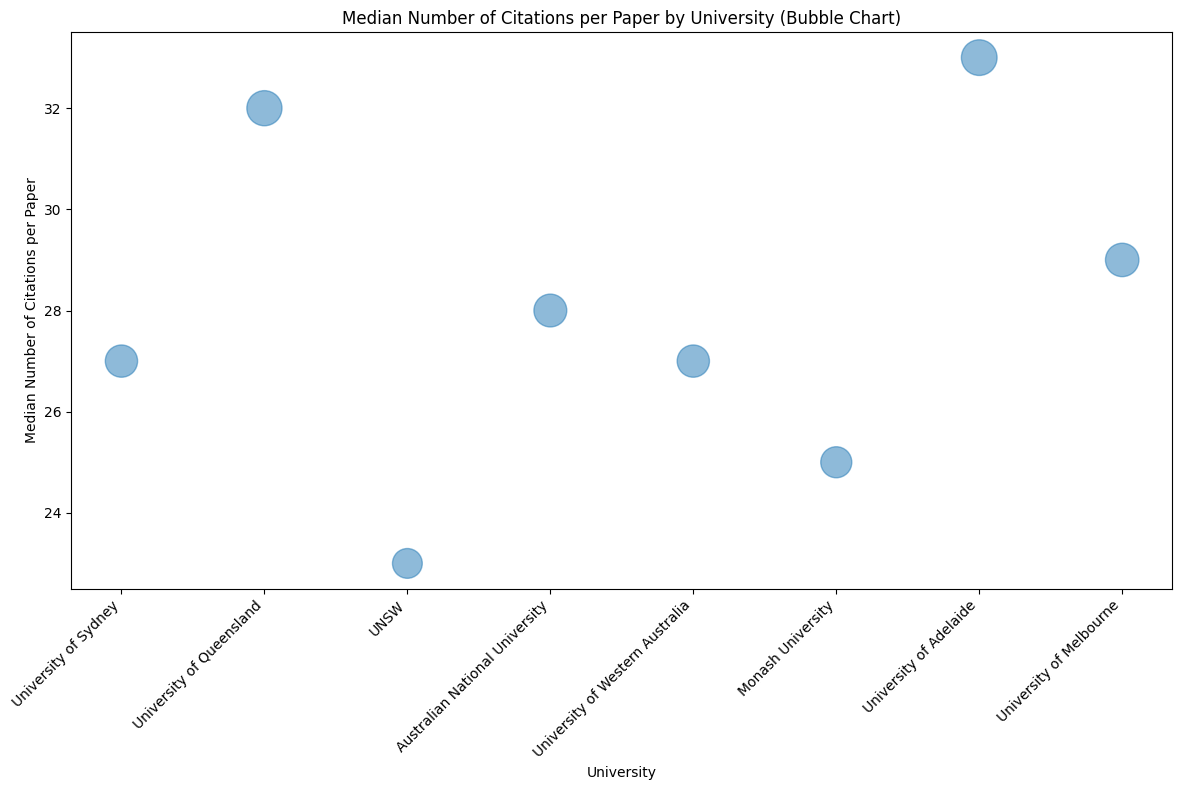

In [28]:
# Plotting using Matplotlib (bubble chart)
plt.figure(figsize=(12, 8))
plt.scatter(citations_df['University'], citations_df['Median Citations per Paper'], s=citations_df['Median Citations per Paper']*20, alpha=0.5)
plt.xlabel('University')
plt.ylabel('Median Number of Citations per Paper')
plt.title('Median Number of Citations per Paper by University (Bubble Chart)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
import networkx as nx

# Function to create collaboration network (example using fabricated data)
def create_collaboration_network(author_data):
    G = nx.Graph()
    for affiliation, authors in author_data.items():
        for author in authors:
            G.add_node(author['name'], university=affiliation)
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    if coauthor['scopus_id'] != author['scopus_id']:
                        G.add_edge(author['name'], coauthor['name'], weight=pub['citations'])
    return G

# Example usage:
collaboration_graph = create_collaboration_network(author_data)

# Plotting using NetworkX (basic graph layout)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(collaboration_graph, k=0.3, iterations=50)
nx.draw_networkx_nodes(collaboration_graph, pos, node_color='skyblue', node_size=300, alpha=0.8)
nx.draw_networkx_edges(collaboration_graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(collaboration_graph, pos, font_size=10, font_family='sans-serif')
plt.title('Collaboration Network Visualization')
plt.axis('off')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

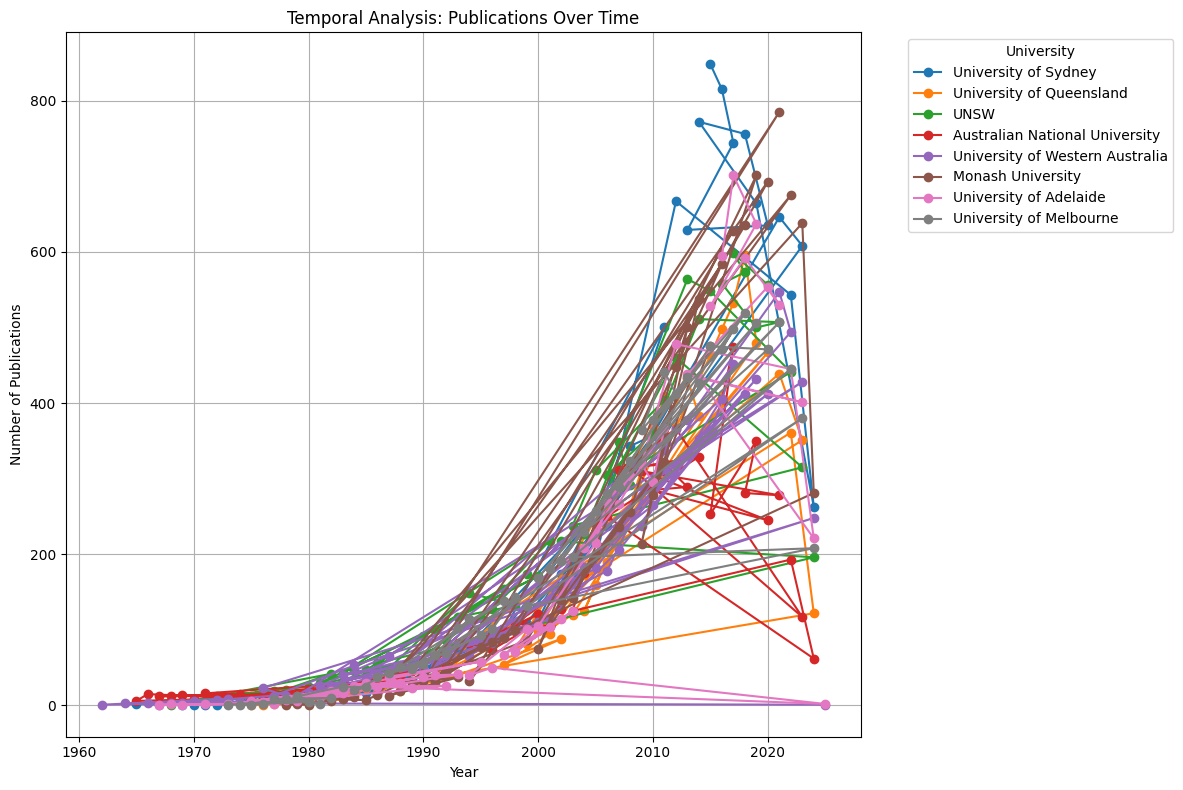

In [30]:
# Function to extract temporal data (example using fabricated data)
def temporal_analysis(author_data):
    temporal_data = []
    for affiliation, authors in author_data.items():
        publications_over_time = {}
        for author in authors:
            for pub in author['publications']:
                year = int(pub['cover_date'][:4]) if pub['cover_date'] else None
                if year:
                    if year in publications_over_time:
                        publications_over_time[year] += 1
                    else:
                        publications_over_time[year] = 1
        temporal_data.append({
            'University': affiliation,
            'Publications Over Time': publications_over_time
        })
    return temporal_data

# Example usage:
temporal_data = temporal_analysis(author_data)

# Plotting using Matplotlib (line chart)
plt.figure(figsize=(12, 8))
for data in temporal_data:
    university = data['University']
    years = list(data['Publications Over Time'].keys())
    counts = list(data['Publications Over Time'].values())
    plt.plot(years, counts, marker='o', label=university)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Temporal Analysis: Publications Over Time')
plt.legend(title='University', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


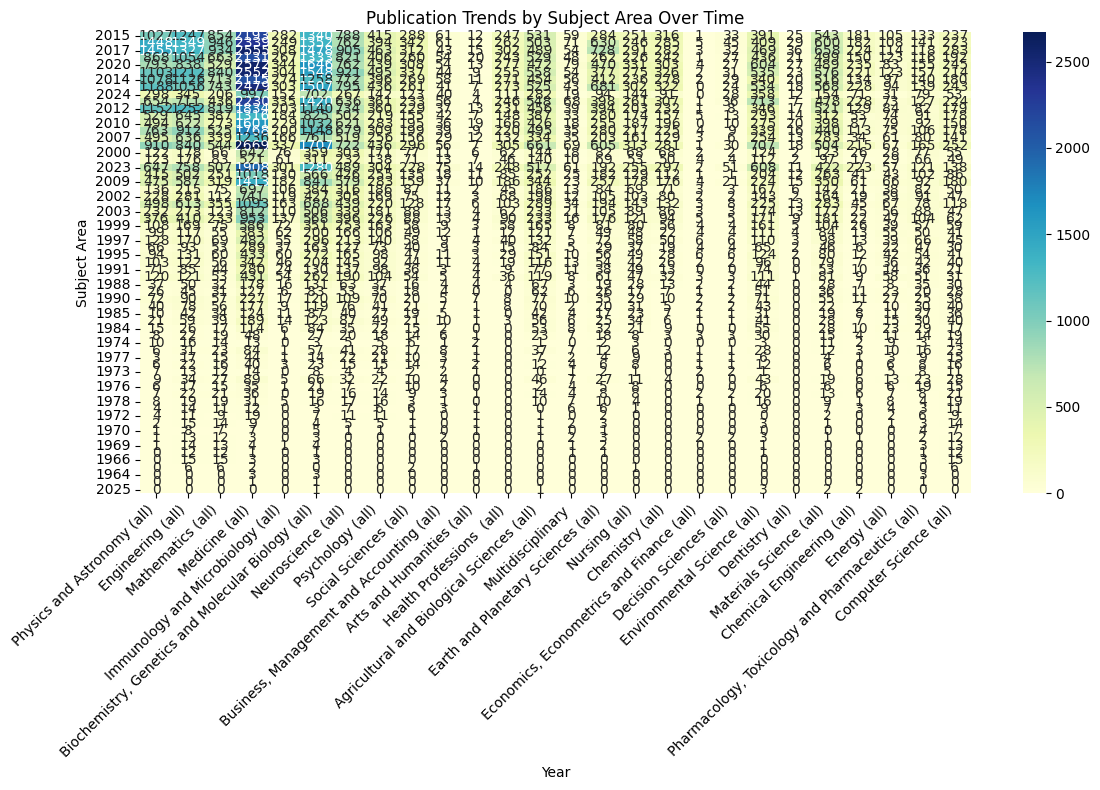

In [31]:
# Function to prepare data for heatmap (example using fabricated data)
def publication_heatmap_data(author_data):
    heatmap_data = {}
    for affiliation, authors in author_data.items():
        for author in authors:
            for pub in author['publications']:
                year = int(pub['cover_date'][:4]) if pub['cover_date'] else None
                if year:
                    for subject in author['subject_area']:
                        subject_name = subject['$']
                        if subject_name not in heatmap_data:
                            heatmap_data[subject_name] = {}
                        if year in heatmap_data[subject_name]:
                            heatmap_data[subject_name][year] += 1
                        else:
                            heatmap_data[subject_name][year] = 1
    heatmap_df = pd.DataFrame(heatmap_data).fillna(0)
    return heatmap_df

# Example usage:
heatmap_df = publication_heatmap_data(author_data)

# Plotting using Seaborn (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap='YlGnBu', annot=True, fmt='g')
plt.xlabel('Year')
plt.ylabel('Subject Area')
plt.title('Publication Trends by Subject Area Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Example code to fetch and store geographic details from Scopus (not implemented here)

# Assuming you have fetched geographic details and stored in a CSV
# Example CSV structure: scopus_id, name, affiliation_id, city, country

# Function to plot geographical distribution of co-authors
def plot_geographical_distribution(geographic_data):
    # Example using a simplified approach, assuming you have geographic data
    plt.figure(figsize=(12, 8))
    # Example plot with random data
    x = np.random.rand(100)
    y = np.random.rand(100)
    plt.scatter(x, y, c=x+y, cmap='viridis', s=100, alpha=0.5)
    plt.colorbar(label='Sum of Coordinates')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographical Distribution of Co-authors')
    plt.tight_layout()
    plt.show()

# Example usage:
# geographic_data = pd.read_csv('geographic_data.csv')
# plot_geographical_distribution(geographic_data)


In [ ]:
from wordcloud import WordCloud

# Function to generate word cloud from keywords
def generate_wordcloud(author_data):
    keywords_text = ''
    for affiliation, authors in author_data.items():
        for author in authors:
            for pub in author['publications']:
                if 'keywords' in pub:
                    keywords_text += ' '.join(pub['keywords']) + ' '
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Keyword Word Cloud')
    plt.tight_layout()
    plt.show()

# Example usage:
generate_wordcloud(author_data)


In [ ]:
# Example code for generating bubble chart based on keywords and citation count
# This example assumes you have keywords and citation data prepared from author_data

# Plotting using Matplotlib (bubble chart)
plt.figure(figsize=(12, 8))
# Example data for bubble chart (replace with actual data)
keywords = ['Machine Learning', 'Data Science', 'Artificial Intelligence', 'Big Data']
citation_counts = [100, 80, 120, 90]
plt.scatter(keywords, keywords, s=citation_counts, alpha=0.5)
plt.xlabel('Keywords')
plt.ylabel('Keywords')
plt.title('Keyword Bubble Chart')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Example function to calculate collaboration density (not implemented here)

# Function to plot collaboration density heatmap or matrix
def plot_collaboration_density(collaboration_data):
    # Example using a simplified approach, assuming you have collaboration data
    plt.figure(figsize=(12, 8))
    # Example heatmap with random data
    data = np.random.rand(10, 10)
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.xlabel('University')
    plt.ylabel('University')
    plt.title('Collaboration Density Heatmap')
    plt.tight_layout()
    plt.show()

# Example usage:
# collaboration_data = calculate_collaboration_density(author_data)
# plot_collaboration_density(collaboration_data)


In [ ]:
# Example function to calculate impact factor and citations (not implemented here)

# Function to plot publication impact factor scatter plot
def plot_publication_impact(author_data):
    # Example using a simplified approach, assuming you have impact factor and citation data
    plt.figure(figsize=(12, 8))
    # Example scatter plot with random data
    x = np.random.rand(100)
    y = np.random.rand(100) * 1000
    sizes = np.random.rand(100) * 100
    plt.scatter(x, y, s=sizes, alpha=0.5)
    plt.xlabel('Citations')
    plt.ylabel('Publication Year')
    plt.title('Publication Impact Factor')
    plt.tight_layout()
    plt.show()

# Example usage:
# impact_data = calculate_publication_impact(author_data)
# plot_publication_impact(impact_data)


In [ ]:
# Function to calculate comparison metrics for radar chart (example using fabricated data)
def comparison_metrics(author_data):
    metrics_data = []
    for affiliation, authors in author_data.items():
        total_citations = sum(pub['citations'] for author in authors for pub in author['publications'])
        total_publications = sum(len(author['publications']) for author in authors)
        median_citations_per_paper = np.median([pub['citations'] for author in authors for pub in author['publications']])
        metrics_data.append({
            'University': affiliation,
            'Total Citations': total_citations,
            'Total Publications': total_publications,
            'Median Citations per Paper': median_citations_per_paper
        })
    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

# Example usage:
metrics_df = comparison_metrics(author_data)

# Plotting using Matplotlib (radar chart)
attributes = list(metrics_df.columns[1:])
values = metrics_df.values[:, 1:].tolist()

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
angles += angles[:1]

for i in range(len(values)):
    values_row = values[i]
    ax.fill(angles, values_row, alpha=0.25)
    ax.plot(angles, values_row)

ax.set_yticklabels([])
plt.xticks(angles[:-1], attributes)
plt.title('Comparison Metrics by University (Radar Chart)')
plt.legend(metrics_df['University'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()
